In [32]:
# Install required packages
#!pip install matplotlib rustworkx numpy scipy
#!pip install qiskit qiskit-ibm-runtime
#!pip install pylatexenc
#!pip install qiskit-aer

In [62]:
# Import packages
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
import networkx as nx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence


from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [63]:
# Load the data
import pandas as pd

data = {
    "Source": [
        "Akosombo", "Akosombo", "Akosombo", "Akosombo", "Akosombo",
        "Akosombo", "Akosombo", "Akosombo", "Akosombo", "Akosombo",
        "Bui", "Bui", "Bui", "Bui", "Bui",
        "Bui", "Bui", "Bui", "Bui", "Bui"
    ],
    "Town": [
        "Town_1", "Town_2", "Town_3", "Town_4", "Town_5",
        "Town_6", "Town_7", "Town_8", "Town_9", "Town_10",
        "Town_1", "Town_2", "Town_3", "Town_4", "Town_5",
        "Town_6", "Town_7", "Town_8", "Town_9", "Town_10"
    ],
    "Distance_km": [
        358, 307, 393, 463, 343,
        435, 241, 493, 326, 210,
        363, 71, 302, 285, 394,
        98, 108, 219, 237, 320
    ],
    "Energy_Demand_kWh": [
        45795, 30860, 84886, 36265, 67194,
        74131, 90263, 46023, 71090, 97221,
        45795, 30860, 84886, 36265, 67194,
        74131, 90263, 46023, 71090, 97221
    ],
    "Max_Line_Capacity_kWh": [
        50000, 150000, 150000, 50000, 50000,
        150000, 100000, 50000, 100000, 100000,
        100000, 50000, 100000, 50000, 100000,
        150000, 150000, 50000, 150000, 150000
    ],
    "Transmission_Cost": [
        1639461.0, 947402.0, 3336019.8, 1679069.5, 1715000.0,
        3224698.5, 2175338.3, 2268933.9, 2317534.0, 2041641.0,
        1662358.5, 219106.0, 2563557.2, 1033552.5, 2647443.6,
        726483.8, 974840.4, 1007903.7, 1684833.0, 3111072.0
    ]
}

df = pd.DataFrame(data)

# Preview the dataset
print(df)


      Source     Town  Distance_km  Energy_Demand_kWh  Max_Line_Capacity_kWh  \
0   Akosombo   Town_1          358              45795                  50000   
1   Akosombo   Town_2          307              30860                 150000   
2   Akosombo   Town_3          393              84886                 150000   
3   Akosombo   Town_4          463              36265                  50000   
4   Akosombo   Town_5          343              67194                  50000   
5   Akosombo   Town_6          435              74131                 150000   
6   Akosombo   Town_7          241              90263                 100000   
7   Akosombo   Town_8          493              46023                  50000   
8   Akosombo   Town_9          326              71090                 100000   
9   Akosombo  Town_10          210              97221                 100000   
10       Bui   Town_1          363              45795                 100000   
11       Bui   Town_2           71      

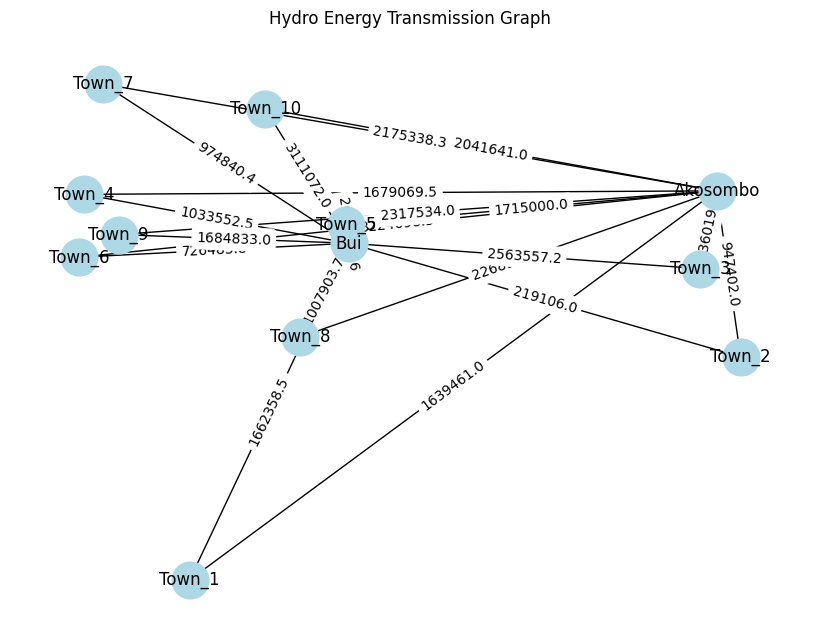

In [66]:
# Create a graph
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_edge(row['Source'], row['Town'], weight=row['Transmission_Cost'])

pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue")
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Hydro Energy Transmission Graph")
plt.show()

In [67]:
# Assign each node an index
node_list = list(G.nodes())
node_index = {node: i for i, node in enumerate(node_list)}

num_nodes = len(node_list)
num_edges = len(G.edges())

In [68]:
# QUBO: Minimize total transmission cost
weights = {}
for u, v, d in G.edges(data=True):
    i, j = node_index[u], node_index[v]
    weights[(i, j)] = d['weight']

# Build Pauli terms with coefficients
pauli_list = []
for (i, j), w in weights.items():
    z = ['I'] * num_nodes
    z[i] = 'Z'
    z[j] = 'Z'
    pauli_str = ''.join(z)
    pauli_list.append((pauli_str, w))

# Create cost Hamiltonian
cost_hamiltonian = SparsePauliOp.from_list(pauli_list)
print("Cost Function Hamiltonian:", cost_hamiltonian)


Cost Function Hamiltonian: SparsePauliOp(['ZZIIIIIIIIII', 'ZIZIIIIIIIII', 'ZIIZIIIIIIII', 'ZIIIZIIIIIII', 'ZIIIIZIIIIII', 'ZIIIIIZIIIII', 'ZIIIIIIZIIII', 'ZIIIIIIIZIII', 'ZIIIIIIIIZII', 'ZIIIIIIIIIZI', 'IZIIIIIIIIIZ', 'IIZIIIIIIIIZ', 'IIIZIIIIIIIZ', 'IIIIZIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIZIIIZ', 'IIIIIIIIZIIZ', 'IIIIIIIIIZIZ', 'IIIIIIIIIIZZ'],
              coeffs=[1639461. +0.j,  947402. +0.j, 3336019.8+0.j, 1679069.5+0.j, 1715000. +0.j,
 3224698.5+0.j, 2175338.3+0.j, 2268933.9+0.j, 2317534. +0.j, 2041641. +0.j,
 1662358.5+0.j,  219106. +0.j, 2563557.2+0.j, 1033552.5+0.j, 2647443.6+0.j,
  726483.8+0.j,  974840.4+0.j, 1007903.7+0.j, 1684833. +0.j, 3111072. +0.j])


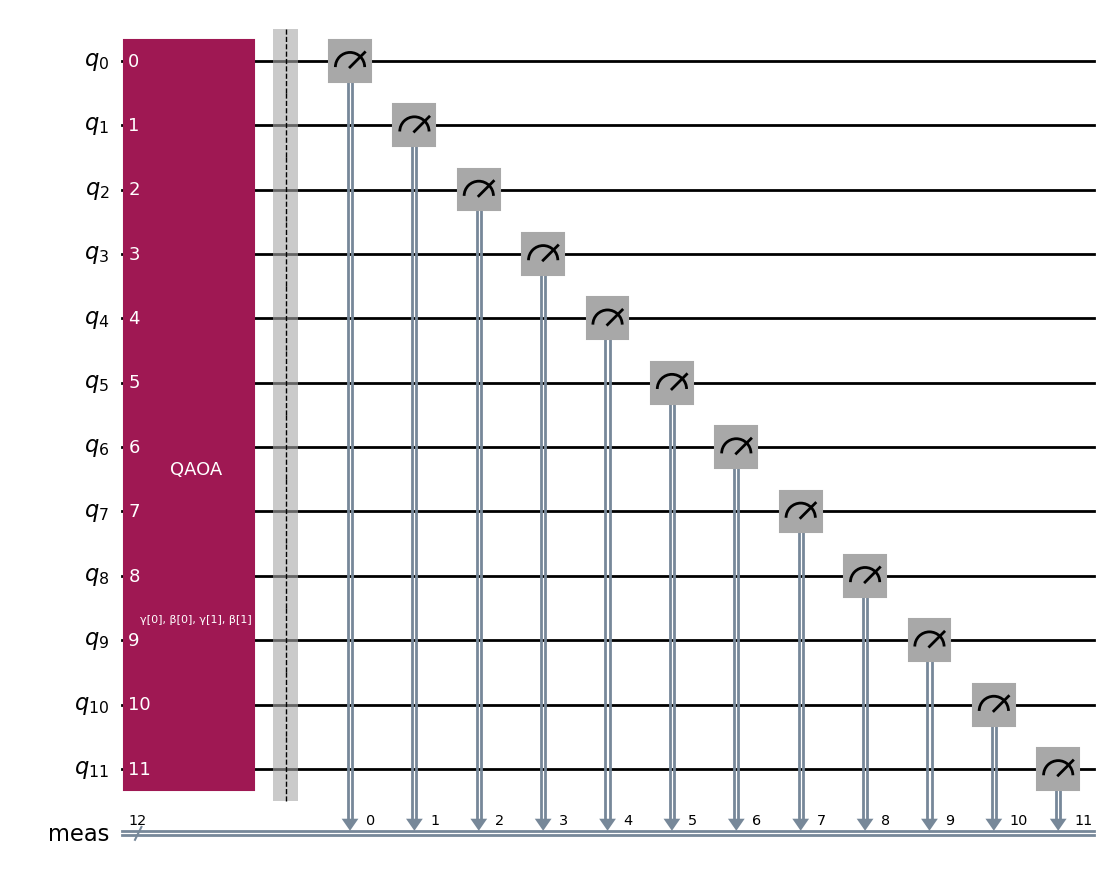

In [69]:
# Create a quantum circuit
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw("mpl")

In [70]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

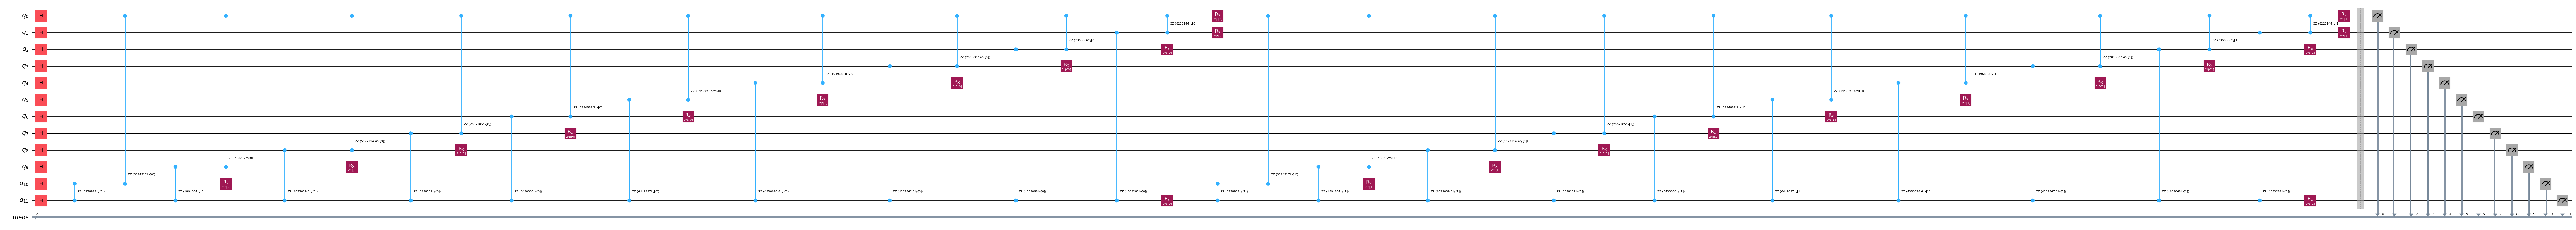

In [71]:
backend = AerSimulator()

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [72]:
# Define circuit with initial parameters
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [73]:
# Define and execute an optimization method
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [76]:
objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        options={"maxiter": 200, "rhobeg": 1, "catol": 1e-2, "tol": 0.0001}
    )
    print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -3943407.2656343654
       x: [ 1.575e+00  2.606e+00  3.096e+00  3.182e+00]
    nfev: 36
   maxcv: 0.0


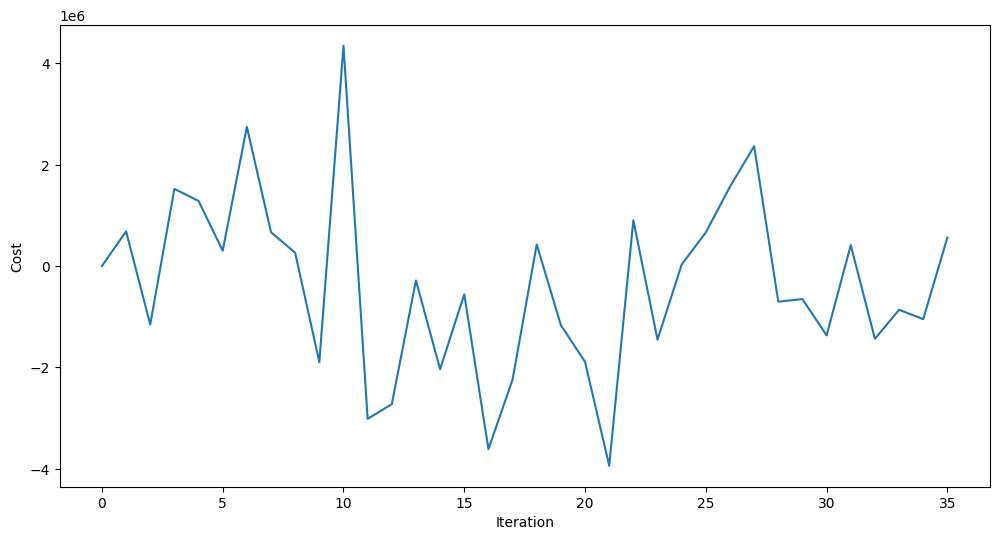

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

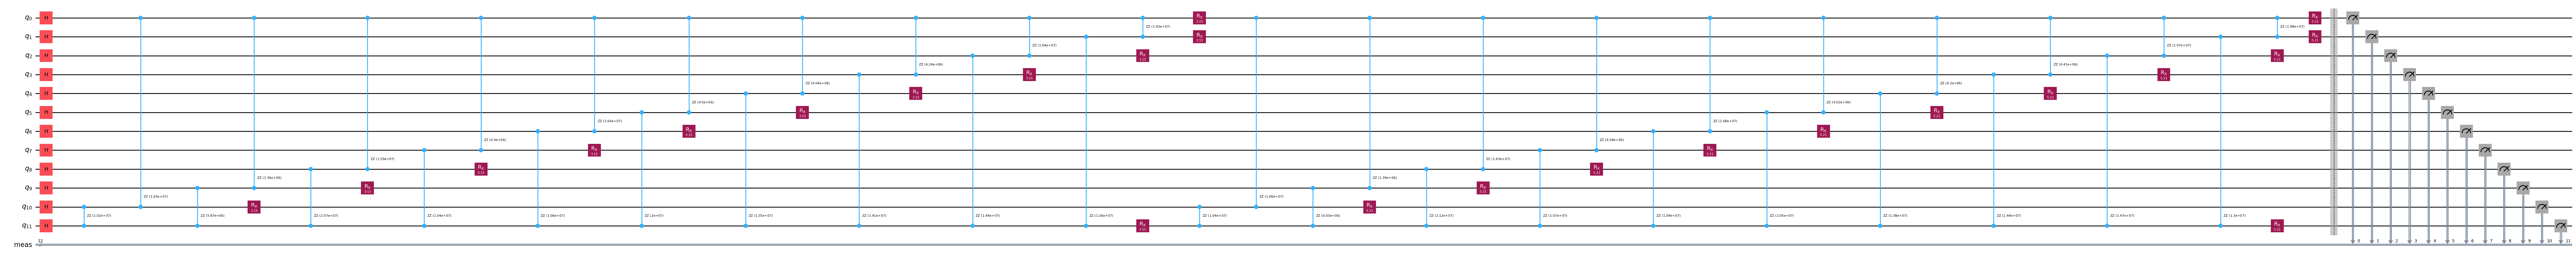

In [78]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [79]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{1317: 0.0048, 669: 0.0005, 1445: 0.0135, 2769: 0.0003, 3500: 0.002, 702: 0.0007, 1214: 0.0003, 835: 0.0003, 700: 0.0022, 2930: 0.0004, 1509: 0.006, 3956: 0.0003, 2833: 0.0003, 1021: 0.001, 547: 0.0003, 2242: 0.0003, 1694: 0.0008, 3828: 0.0005, 2819: 0.0004, 1272: 0.0001, 166: 0.0002, 2047: 0.0005, 2476: 0.0002, 2665: 0.0001, 1453: 0.0139, 1592: 0.0004, 405: 0.0002, 1660: 0.002, 2045: 0.0032, 984: 0.0001, 4069: 0.0006, 3221: 0.0001, 3460: 0.0002, 828: 0.0005, 1324: 0.0016, 1788: 0.0095, 538: 0.0015, 2179: 0.0035, 2058: 0.0003, 3163: 0.0001, 1784: 0.0007, 2375: 0.0009, 1381: 0.0021, 3567: 0.0002, 1413: 0.004, 1454: 0.0022, 1308: 0.0002, 1009: 0.0001, 2051: 0.0151, 1724: 0.0098, 528: 0.0007, 35: 0.0011, 3492: 0.0024, 2115: 0.0121, 1737: 0.0001, 98: 0.0005, 194: 0.0002, 2435: 0.0029, 3363: 0.0004, 1725: 0.0044, 1757: 0.0006, 135: 0.0001, 1061: 0.0004, 664: 0.0007, 2005: 0.0008, 1333: 0.0016, 2419: 0.0002, 3941: 0.0003, 2650: 0.0138, 1461: 0.0027, 2306: 0.0028, 1446: 0.0015, 1630: 0.0001, 

/usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [80]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(G))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]


In [81]:
node_index

{'Akosombo': 0,
 'Town_1': 1,
 'Town_2': 2,
 'Town_3': 3,
 'Town_4': 4,
 'Town_5': 5,
 'Town_6': 6,
 'Town_7': 7,
 'Town_8': 8,
 'Town_9': 9,
 'Town_10': 10,
 'Bui': 11}

Text(0.5, 1.0, 'Result Dist')

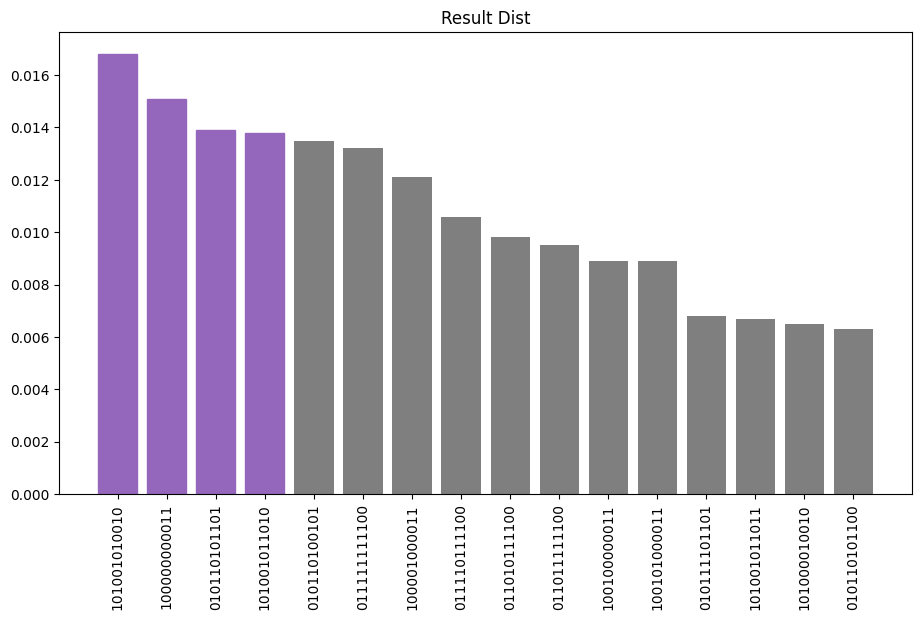

In [82]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 10})

final_bits = final_distribution_bin  # dict: bitstring -> probability

# Filter for probabilities > 0.006
filtered_bits = {k: v for k, v in final_bits.items() if v > 0.006}

# Sort by probability
sorted_items = sorted(filtered_bits.items(), key=lambda x: x[1], reverse=True)
bitstrings = [k for k, v in sorted_items]
values = np.array([v for k, v in sorted_items])

# Get top indices (optional: keep coloring)
top_k = min(4, len(values))
top_indices = np.argsort(values)[-top_k:]

# Plot
fig, ax = plt.subplots(figsize=(11, 6))
bars = ax.bar(bitstrings, values, color="tab:grey")

# Highlight top bars
for idx in top_indices:
    bars[idx].set_color("tab:purple")

# Beautify x-axis
plt.xticks(rotation=90, ha="center")
plt.title("Result Dist")


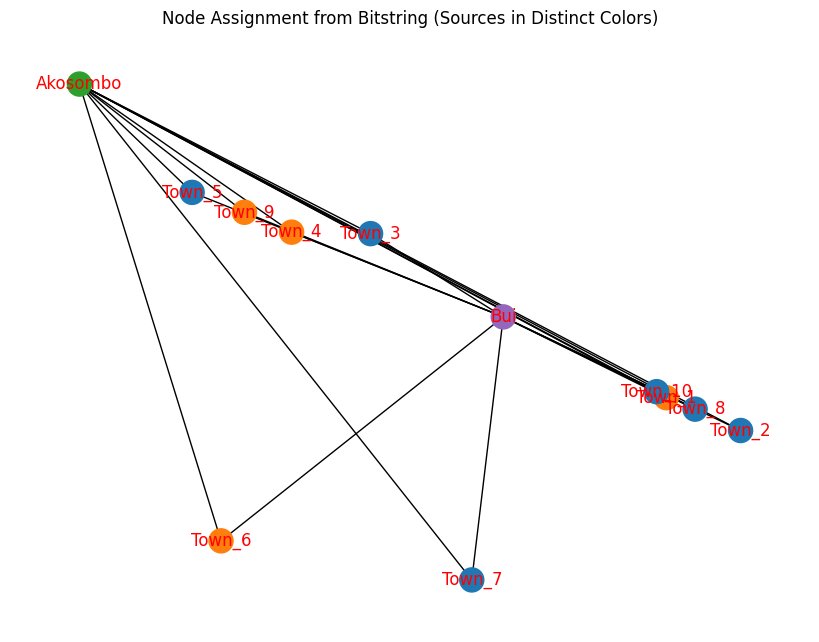

In [83]:
assignment = {node: most_likely_bitstring[idx] for node, idx in node_index.items()}

# Assign colors:
# - Sources: special colors ("green" for Akosombo, "purple" for Bui)
# - Towns: color based on assignment (0=blue:Bui, 1=orange:Akosombo)
color_map = []
for node in G.nodes():
    if node == "Akosombo":
        color_map.append("tab:green")
    elif node == "Bui":
        color_map.append("tab:purple")
    else:
        color_map.append("tab:blue" if assignment[node] == 0 else "tab:orange")

# Draw graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=300, font_color='red')
plt.title("Node Assignment from Bitstring (Sources in Distinct Colors)")
plt.show()